# Libs

In [1]:
# NN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
# ML
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, cohen_kappa_score
from src.scoring import quadratic_kappa_score

# PLOT
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# GENERAL
import sys
import os
from os.path import join

2022-12-02 18:31:23.923931: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 18:31:24.581413: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /data/dist/plumed2/src/lib/:/opt/gromacs/lib:/home/dima/miniconda3/envs/tf/lib/:/home/dima/miniconda3/envs/tf/lib/
2022-12-02 18:31:24.581469: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /data/d

In [2]:
print("TensorFlow version:", tf.__version__)
print(tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.11.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Constants

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
data_folder = "../../data/preprocessed/"

In [23]:
def f1(y_true, y_pred):
    
    y_t = tf.math.argmax(y_true, axis =1).numpy()
    y_p = tf.math.argmax(y_pred, axis =1).numpy()
    p = quadratic_kappa_score(y_t, y_p)

    return p

def tf_kappa(y_true, y_pred):
    labels = tf.argmax(y_true, axis=1).numpy()
    predictions = tf.argmax(y_pred, axis=1).numpy()
    p= quadratic_kappa_score(labels,predictions)
    return tf.constant(p)
                             
def average_recall(y_true, y_pred):
    # Get indexes of both labels and predictions
    labels = tf.argmax(y_true, axis=1)
    predictions = tf.argmax(y_pred, axis=1)
    # Get confusion matrix from labels and predictions
    confusion_matrix = tf.math.confusion_matrix(labels, predictions)
    # Get number of all true positives in each class
    all_true_positives = tf.linalg.diag_part(confusion_matrix)
    # Get number of all elements in each class
    all_class_sum = tf.reduce_sum(confusion_matrix, axis=1)
    # Get rid of classes that don't show in batch
    mask = tf.not_equal(all_class_sum, tf.constant(0))
    all_true_positives = tf.boolean_mask(all_true_positives, mask)
    all_class_sum = tf.boolean_mask(all_class_sum, mask)

    # print("confusion_matrix:\n {},\n all_true_positives:\n {},\n all_class_sum:\n {}".format(
    #                                         confusion_matrix, all_true_positives, all_class_sum))
    # Average TruePositives / TotalElements wrt all classes that show in batch
    return tf.reduce_mean(all_true_positives / all_class_sum)


# Read and process the data

In [6]:
X = pd.read_pickle(join(data_folder, "X.pk.zip"))
y = pd.read_pickle(join(data_folder, "Y.pk.zip"))
X_mat = X.values
y_vec = y.values.flatten()
scaler = StandardScaler()
scaler.fit(X_mat)
X_mat = scaler.transform(X_mat)
x_train, x_test, y_train, y_test = train_test_split(X_mat, y_vec, test_size=0.22, random_state=123)

In [7]:
sys.stdout.write(f"The number of features: {X_mat.shape[1]}\n")
sys.stdout.write(f"TRAIN \
0: {np.sum(y_train == 0)}, 1: {np.sum(y_train == 1)}, 2: {np.sum(y_train == 2)}\n")

sys.stdout.write(f"TEST  \
0: {np.sum(y_test == 0)}, 1: {np.sum(y_test == 1)}, 2: {np.sum(y_test == 2)}\n")


The number of features: 203
TRAIN 0: 1592, 1: 2210, 2: 51352
TEST  0: 449, 1: 625, 2: 14483


31

# Train


## Model

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

2022-12-02 18:31:37.128726: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 18:31:37.591581: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7077 MB memory:  -> device: 0, name: Quadro P4000, pci bus id: 0000:65:00.0, compute capability: 6.1


## Trial for untrained model

In [9]:
predictions = model(x_train[:5]).numpy()
predictions

array([[0.2913773 , 0.4061665 , 0.30245617],
       [0.3163117 , 0.36553723, 0.31815112],
       [0.337952  , 0.30989176, 0.35215628],
       [0.39048392, 0.28833756, 0.32117847],
       [0.36247888, 0.37264976, 0.26487133]], dtype=float32)

In [10]:
y_train_oh = tf.one_hot(y_train, 3).numpy()
y_test_oh = tf.one_hot(y_test, 3).numpy()
y_train_oh[:5,:]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [11]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()
loss_fn(y_train_oh[:5,:], predictions).numpy()

1.1697996

In [26]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=[average_recall])

In [27]:
class_weight = {0:1.2,
               1:1.2,
               2:0.1}
history = model.fit(x_train, y_train_oh, validation_data = (x_test, y_test_oh), epochs=8, class_weight=class_weight)

Epoch 1/8


2022-12-02 18:38:42.138101: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fa99001be20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-02 18:38:42.138127: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro P4000, Compute Capability 6.1
2022-12-02 18:38:42.142007: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-02 18:38:42.203346: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-02 18:38:42.239823: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1724/1724 [==============================] - 7s 3ms/step - loss: 0.1838 - average_recall: 0.4660 - val_loss: 0.7533 - val_average_recall: 0.4844
Epoch 2/8
1724/1724 [==============================] - 5s 3ms/step - loss: 0.1783 - average_recall: 0.4839 - val_loss: 0.7359 - val_average_recall: 0.4816
Epoch 3/8
1724/1724 [==============================] - 5s 3ms/step - loss: 0.1760 - average_recall: 0.4846 - val_loss: 0.7203 - val_average_recall: 0.4886
Epoch 4/8
1724/1724 [==============================] - 4s 3ms/step - loss: 0.1746 - average_recall: 0.4845 - val_loss: 0.6793 - val_average_recall: 0.4911
Epoch 5/8
1724/1724 [==============================] - 4s 2ms/step - loss: 0.1731 - average_recall: 0.4960 - val_loss: 0.6845 - val_average_recall: 0.4934
Epoch 6/8
1724/1724 [==============================] - 4s 2ms/step - loss: 0.1722 - average_recall: 0.4944 - val_loss: 0.7155 - val_average_recall: 0.4880
Epoch 7/8
1724/1724 [==============================] - 4s 2ms/step - loss: 0.170

In [ ]:
# model.evaluate(x_test,  y_train_oh, verbose=2)



In [28]:
RE = model.predict(x_test)
results = tf.math.argmax(RE, axis =1).numpy()

487/487 [==============================] - 0s 728us/step


In [29]:
cm = confusion_matrix(results, y_test)
score2 = quadratic_kappa_score(results, y_test)

In [30]:
print(score2)

0.07939602293713532


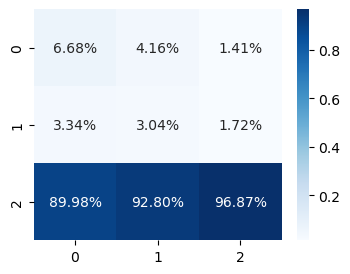

In [31]:
fig, ax = plt.subplots(figsize=(4,3))
sns.heatmap(cm/np.sum(cm, axis=0), annot=True, 
            fmt='.2%', cmap='Blues')
fig.savefig("cm.png")

In [ ]:
# history.history
fig, axs = plt.subplots(2,figsize=(4,3), sharex=True)
fig.suptitle("loss")
axs[0].plot(history.history['loss'], c = 'blue')
axs[1].plot(history.history['val_loss'], c = 'red')
fig.savefig("loss.png")

In [ ]:
fig, axs = plt.subplots(2,figsize=(4,3), sharex=True)
fig.suptitle("average recall")
axs[0].plot(history.history['average_recall'], c = 'blue')
axs[1].plot(history.history['average_recall'], c = 'red')
fig.savefig("loss.png")

In [ ]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
plt.show()

## New Predictions

In [ ]:
X = pd.read_pickle(join(data_folder, "test.pk"))
X_mat = X.values

In [ ]:
X_mat = scaler.transform(X_mat)

In [ ]:
logits = model.predict(X_mat)
results = tf.math.argmax(tf.nn.softmax(logits).numpy(), axis =1)

In [ ]:
predicted_vals = results.numpy()

In [ ]:

report = pd.DataFrame({'Id': X.index, 'pred': predicted_vals})
report.to_csv("submission.csv", index=False)